In [6]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
import lightgbm as lgb


In [7]:
# Đường dẫn file (có thể chỉnh lại cho phù hợp)
# TRAIN_PATH = "D:\vis\Project_DataPreVisual_Group_1\Data\processed\train_processed.csv"
# TEST_PATH  = "D:\vis\Project_DataPreVisual_Group_1\Data\processed\test_processed.csv"

train = pd.read_csv(r"D:\vis\Project_DataPreVisual_Group_1\Data\processed\train_processed.csv")
test  = pd.read_csv(r"D:\vis\Project_DataPreVisual_Group_1\Data\processed\test_processed.csv")
print("Train shape:", train.shape)
print("Test shape :", test.shape)
target_col = "sii"

# Kiểm tra vài dòng
train.head()


Train shape: (2736, 181)
Test shape : (20, 158)


,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,quarter_75%,quarter_max,relative_date_PCIAT_count,relative_date_PCIAT_mean,relative_date_PCIAT_std,relative_date_PCIAT_min,relative_date_PCIAT_25%,relative_date_PCIAT_50%,relative_date_PCIAT_75%,relative_date_PCIAT_max
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,3.0,43330.0,53.201683,14.244915,41.0,42.0,50.0,53.0,85.0
4,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,3.0,3.0,396396.0,79.435593,6.634319,68.0,74.0,79.0,85.0,91.0


Read the file **.csv** and check the first few rows of the train file

## 1. Exploratory analysis

### Data types & memory

In [8]:
train.dtypes.value_counts()
test.dtypes.value_counts()


float64    145
object      11
int64        2
Name: count, dtype: int64

Check the distribution of data types for each column in the train and test sets to see whether the two datasets are similar or different.

In [9]:
for col in train.columns:
    print(f"{col:35}  {train[col].dtype}")

id                                   object
Basic_Demos-Enroll_Season            object
Basic_Demos-Age                      int64
Basic_Demos-Sex                      int64
CGAS-Season                          object
CGAS-CGAS_Score                      float64
Physical-Season                      object
Physical-BMI                         float64
Physical-Height                      float64
Physical-Weight                      float64
Physical-Waist_Circumference         float64
Physical-Diastolic_BP                float64
Physical-HeartRate                   float64
Physical-Systolic_BP                 float64
Fitness_Endurance-Season             object
Fitness_Endurance-Max_Stage          float64
Fitness_Endurance-Time_Mins          float64
Fitness_Endurance-Time_Sec           float64
FGC-Season                           object
FGC-FGC_CU                           float64
FGC-FGC_CU_Zone                      float64
FGC-FGC_GSND                         float64
FGC-FGC_GSND_Zone   

### Numeric summary (key columns)

In [10]:
cols = ["Basic_Demos-Age", "Physical-BMI",
        "Physical-Height", "PreInt_EduHx-computerinternet_hoursday"]
train[cols].describe().T


,count,mean,std,min,25%,50%,75%,max
Basic_Demos-Age,2736.0,10.238670,3.427982,5.0,8.000000,10.00000,12.000000,22.000000
Physical-BMI,2527.0,19.125667,4.909305,0.0,15.773447,17.81901,21.172311,46.102914
Physical-Height,2530.0,55.897051,7.394938,36.0,50.050000,55.00000,61.750000,78.500000
PreInt_EduHx-computerinternet_hoursday,2654.0,1.015072,1.080861,0.0,0.000000,1.00000,2.000000,3.000000


Calculate descriptive statistics (**mean, std, min, max, etc.**) for the 4 selected columns in the train set, then transpose the table for easier readability.

### Missing values (top)

In [11]:
def missing_summary(df, name="df", top_n=30):
    mis = df.isna().mean().sort_values(ascending=False)
    print(f"\n=== Missing ratio in {name} (top {top_n}) ===")
    display(mis.head(top_n))
    
    plt.figure(figsize=(10,4))
    mis.head(top_n).plot(kind="bar")
    plt.title(f"Missing ratio in {name}")
    plt.ylabel("Ratio")
    plt.show()


**Purpose:** 
* Calculates the missing value ratio for each column.

* Displays a table of the top 30 columns with the most missing values.

* Plots a visual bar chart for easier interpretation.

**Which includes**
* **top_n**: number of columns with the highest missing ratios to display

* **df.isna()**: returns True/False for each cell, True if NaN

* **.mean()**: calculates the percentage of NaN for each column

* **.sort_values(ascending=False)**: sorts columns from highest to lowest missing ratio

* **display(mis.head(top_n))**: shows the top_n columns with the most missing values


=== Missing ratio in train (top 30) ===


PAQ_A-PAQ_A_Total               0.867325
PAQ_A-Season                    0.867325
Physical-Waist_Circumference    0.823465
Fitness_Endurance-Time_Mins     0.733918
Fitness_Endurance-Time_Sec      0.733918
Fitness_Endurance-Max_Stage     0.732822
FGC-FGC_GSND_Zone               0.684211
FGC-FGC_GSD_Zone                0.684211
FGC-FGC_GSD                     0.681652
FGC-FGC_GSND                    0.681287
light_50%                       0.635965
light_75%                       0.635965
light_max                       0.635965
battery_voltage_count           0.635965
battery_voltage_mean            0.635965
battery_voltage_std             0.635965
battery_voltage_min             0.635965
battery_voltage_25%             0.635965
enmo_max                        0.635965
enmo_50%                        0.635965
enmo_75%                        0.635965
X_count                         0.635965
X_mean                          0.635965
X_std                           0.635965
X_min           

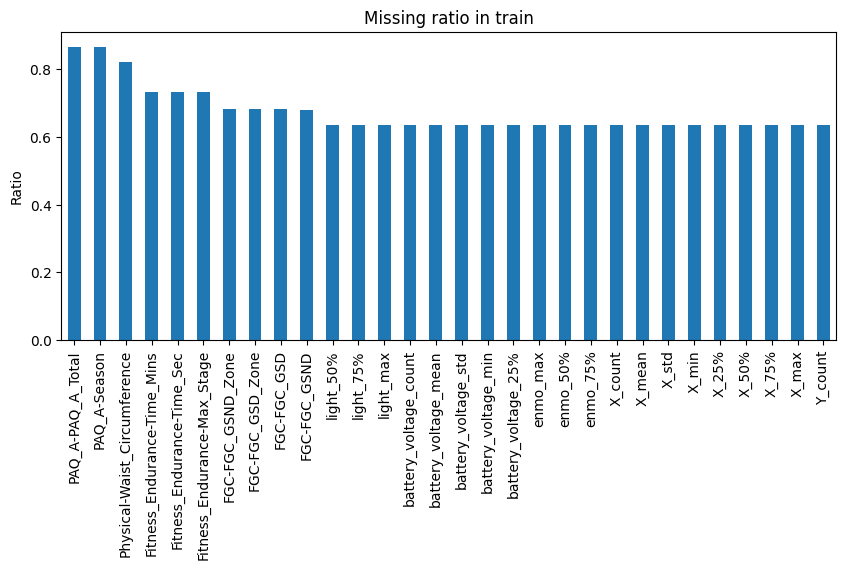


=== Missing ratio in test (top 30) ===


PAQ_A-PAQ_A_Total    0.95
PAQ_A-Season         0.95
X_25%                0.90
X_50%                0.90
X_std                0.90
X_min                0.90
Y_count              0.90
Y_mean               0.90
Y_std                0.90
Y_min                0.90
Y_25%                0.90
Y_50%                0.90
X_75%                0.90
X_max                0.90
Z_count              0.90
Z_mean               0.90
Z_std                0.90
Z_min                0.90
Z_25%                0.90
Z_50%                0.90
Z_75%                0.90
Z_max                0.90
enmo_count           0.90
enmo_mean            0.90
enmo_std             0.90
sedentary_por        0.90
moderate_por         0.90
light_por            0.90
Y_75%                0.90
Y_max                0.90
dtype: float64

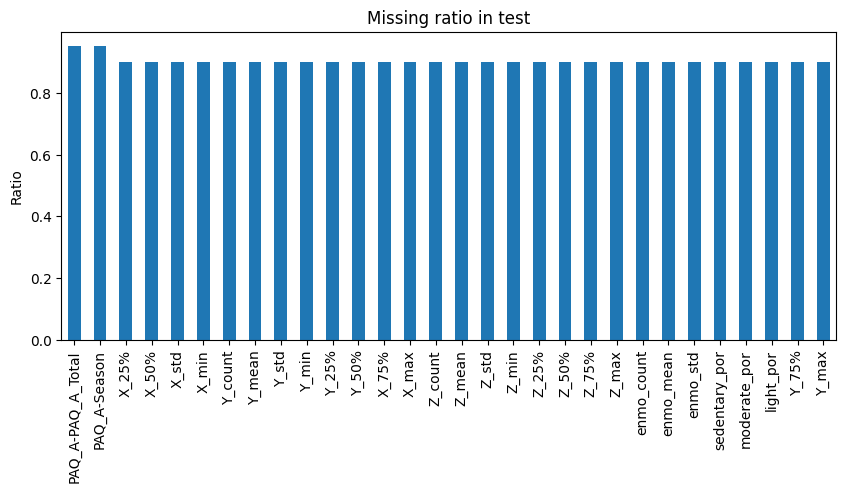

In [12]:
missing_summary(train, "train")
missing_summary(test, "test")


Checks missing value ratios for both train and test datasets

In [13]:
train_cols = set(train.columns)
test_cols  = set(test.columns)

only_in_train = train_cols - test_cols
only_in_test  = test_cols - train_cols

print("Only in train:", only_in_train)
print("Only in test :", only_in_test)

Only in train: {'PCIAT-PCIAT_Total', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_09', 'sii', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_13', 'PCIAT-Season', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_14'}
Only in test : set()


**Purpose:** 

Check the differences in columns between the train and test sets by identifying which columns are missing or extra.

In [14]:
drop_from_train = [c for c in only_in_train if c != target_col]
drop_from_test  = list(only_in_test)   # thường cũng nên drop

print("Drop from train:", drop_from_train)
print("Drop from test :", drop_from_test)

train = train.drop(columns=drop_from_train)
test  = test.drop(columns=drop_from_test)

print("New shapes => Train:", train.shape, "Test:", test.shape)

Drop from train: ['PCIAT-PCIAT_Total', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_13', 'PCIAT-Season', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_14']
Drop from test : []
New shapes => Train: (2736, 159) Test: (20, 158)


**Purrpose:** 

* It synchronizes the column sets between the train and test datasets by removing extra columns that appear in only one of them.

**Which include**

* The list comprehension keeps all columns that need to be dropped except the target column (**target_col**), because the label must remain in the training set. 

In [15]:
# Đảm bảo không có id trong feature
train_id = train["id"].copy()
test_id  = test["id"].copy()
if id:
    train = train.drop(columns='id')
    test  = test.drop(columns=['id'] if 'id' in test.columns else [])

print("Shape after ID drop =>", train.shape, test.shape)


Shape after ID drop => (2736, 158) (20, 157)


**Purpose:** 

Save the id column, then remove it from the train and test datasets, and finally print their new shapes.

**Note:**

Removing the id column ensures that the model does not use the ID as a feature.


### Categorical / object columns

In [16]:
train_obj_cols = train.select_dtypes("object").columns.tolist()
train[train_obj_cols].nunique().sort_values(ascending=False)


Basic_Demos-Enroll_Season    4
CGAS-Season                  4
Physical-Season              4
Fitness_Endurance-Season     4
FGC-Season                   4
BIA-Season                   4
PAQ_A-Season                 4
PAQ_C-Season                 4
SDS-Season                   4
PreInt_EduHx-Season          4
dtype: int64

**Purpose:**

To identify all object-type columns in the train dataset and count the number of unique values in each, sorted from highest to lowest.

### Duplicates

In [17]:
print("Train duplicates:", train.duplicated().sum())
print("Test duplicates :", test.duplicated().sum())

Train duplicates: 0
Test duplicates : 0


## 2. Grouping strategy (your schema + fixes)

In [18]:
def count_and_percent(cols, total):
    return f"{len(cols)} columns ({len(cols)/total*100:.1f}%)"

def print_group(name, cols):
    print(f"\n{name}: {count_and_percent(cols, total_cols)}")
    print(cols)


# ================================
# 0. Meta info
# ================================
total_cols = len(train.columns)
print(f"TOTAL COLUMNS IN TRAIN: {total_cols}\n")

# 1. Season
season_cols = [
    c for c in train.columns
    if c.endswith("-Season") or c.endswith("-season") or c.endswith("_Season")
]

# 2. Demographics
demo_cols = ["Basic_Demos-Age", "Basic_Demos-Sex"]

# 3. Physical
physical_cols = [c for c in train.columns
                 if c.startswith("Physical-") and c not in season_cols]

# 4. Fitness
fitness_cols  = [c for c in train.columns
                 if c.startswith("Fitness_Endurance-") and c not in season_cols]

# 5. FGC
fgc_cols      = [c for c in train.columns
                 if c.startswith("FGC-") and c not in season_cols]
fgc_zone_cols  = [c for c in fgc_cols if "_Zone" in c]
fgc_score_cols = [c for c in fgc_cols if "_Zone" not in c]

# 6. BIA
bia_cols = [c for c in train.columns
            if c.startswith("BIA-") and c not in season_cols]

# 7. PAQ
paq_cols = [c for c in train.columns
            if (c.startswith("PAQ_A-") or c.startswith("PAQ_C-"))
            and c not in season_cols]

# 8. SDS
sds_cols = [c for c in train.columns
            if c.startswith("SDS-") and c not in season_cols]

# 9. PCIAT (removed)
pciat_cols = [c for c in train.columns
              if c.startswith("PCIAT-") and c not in season_cols]

# 10. Internet
internet_cols = ["PreInt_EduHx-computerinternet_hoursday"]

# 11. CGAS
cgas_cols = ["CGAS-CGAS_Score"]

# 12. Actigraphy POR
act_por_cols = ["sedentary_por", "light_por", "moderate_por"]

# 13. Actigraphy RAW (everything else numeric not in the above)
exclude_for_act = (
    season_cols + demo_cols + physical_cols + fitness_cols +
    fgc_cols + bia_cols + paq_cols + sds_cols + pciat_cols +
    internet_cols + cgas_cols + act_por_cols + ["sii"]
)
if "id" in train.columns:
    exclude_for_act += ["id"]   # FIX: don't treat id as actigraphy

act_cols = [c for c in train.columns if c not in exclude_for_act]

# 14. VALIDATE — Sum == total_cols?
total_grouped = (
    len(season_cols) +
    len(demo_cols) +
    len(physical_cols) +
    len(fitness_cols) +
    len(fgc_cols) +
    len(bia_cols) +
    len(paq_cols) +
    len(sds_cols) +
    len(pciat_cols) +
    len(internet_cols) +
    len(cgas_cols) +
    len(act_por_cols) +
    len(act_cols) +
    1  # sii target
)

print("\nCHECK TOTAL:", total_grouped, "vs", total_cols)


# ================================
# 15. Print groups
# ================================
print_group("Season columns", season_cols)
print_group("Demographic columns", demo_cols)
print_group("Physical columns", physical_cols)
print_group("Fitness columns", fitness_cols)
print_group("FGC columns", fgc_cols)
print_group("BIA columns", bia_cols)
print_group("PAQ columns", paq_cols)
print_group("SDS columns", sds_cols)
print_group("PCIAT columns", pciat_cols)
print_group("Internet columns", internet_cols)
print_group("CGAS columns", cgas_cols)
print_group("Actigraphy POR columns", act_por_cols)
print_group("Actigraphy RAW columns", act_cols)


TOTAL COLUMNS IN TRAIN: 158


CHECK TOTAL: 158 vs 158

Season columns: 10 columns (6.3%)
['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

Demographic columns: 2 columns (1.3%)
['Basic_Demos-Age', 'Basic_Demos-Sex']

Physical columns: 7 columns (4.4%)
['Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP']

Fitness columns: 3 columns (1.9%)
['Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec']

FGC columns: 14 columns (8.9%)
['FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone']

BIA columns: 16 columns (10.1%)
['BIA-BIA_Activ

**Note**

We automatically categorize features into domain-specific groups (season, demographics, physical, fitness, internet use, actigraphy, etc.) to streamline subsequent processing steps such as imputation, encoding, and outlier handling.

Utility functions are used to display group sizes and percentages. Each group is constructed by filtering column names based on predefined patterns or prefixes, with FGC features further split into zone-level and score-level subsets.

Remaining columns not assigned to any domain group—after excluding all known groups and the target sii—are classified as raw actigraphy features.

A validation step compares the total number of grouped columns with the actual number of columns in the dataset to ensure full coverage. All groups are then printed for quick inspection and verification.

## 3. Detailed cleaning logic

### Drop id during feature cleaning

In [19]:
train_clean = train.copy()
test_clean  = test.copy()

id_col = "id" if "id" in train_clean.columns else None
if id_col:
    train_id = train_clean[id_col].copy()
    test_id  = test_clean[id_col].copy()
    train_clean = train_clean.drop(columns=[id_col])
    test_clean  = test_clean.drop(columns=[id_col])


**Purpose:**

Prepare “**clean**” train/test datasets for the model to learn from by removing the ID column, while still keeping its values for later use if needed.

### Fix impossible BMI values

In [20]:
if "Physical-BMI" in train_clean.columns:
    train_clean.loc[train_clean["Physical-BMI"] == 0, "Physical-BMI"] = np.nan
if "Physical-BMI" in test_clean.columns:
    test_clean.loc[test_clean["Physical-BMI"] == 0, "Physical-BMI"] = np.nan


**Purpose:**

Remove **BMI = 0** values, as they are invalid, preparing the data for subsequent missing value imputation.

 **Note:**

* **.loc[condition, "column"]** → selects rows that satisfy the condition in the specified column

* **train_clean["Physical-BMI"]** == 0 → selects all rows where BMI = 0

* Assign **np.nan** to mark it as a missing value

### Season columns (meta categories)

In [21]:
for df in (train_clean, test_clean):
    for c in season_cols:
        if c in df.columns:
            df[c] = (
                df[c].astype(str)
                     .str.strip()
                     .str.lower()
                     .replace({"nan": "missing"})
            )


**Purpose:**

* Standardize categorical string data

* Remove leading and trailing whitespace

* Convert all characters to lowercase to avoid duplicate categories

* Replace **NaN** values converted to the string "**nan**" with "**missing**"

### Demographics

In [22]:
age_median = train_clean["Basic_Demos-Age"].median()
train_clean["Basic_Demos-Age"] = train_clean["Basic_Demos-Age"].fillna(age_median)
test_clean["Basic_Demos-Age"]  = test_clean["Basic_Demos-Age"].fillna(age_median)


**Purpose:**

Fill missing values in the age column with the train median, maintaining consistency between train and test and avoiding the influence of outliers.

**Note:**

* **fillna(age_median)** → replaces all NaN values with age_median

* Use the median from train to fill missing values in test

* Ensures no data leakage from test to train

### FGC (motor / balance)

#### FGC Zone (ordinal MNAR)

In [23]:
for col in fgc_zone_cols:
    train_clean[col + "_missing"] = train_clean[col].isna().astype(int)
    if col in test_clean.columns:
        test_clean[col + "_missing"] = test_clean[col].isna().astype(int)

    train_clean[col] = train_clean[col].fillna(-1)
    if col in test_clean.columns:
        test_clean[col] = test_clean[col].fillna(-1)


**Purpose:** 

* Create a **_missing** flag column for each FGC zone to record missing data

* Fill missing values with **-1** to keep the columns numeric for modeling
    
    **(This approach preserves missing information while allowing the model to learn from numeric data.)**

**Note:**

* **isna()** → checks for NaN values (True if missing)

* **.astype(int)** → converts True/False to 1/0

* Creates a new column ending with **_missing** to indicate whether the value was missing

* **NaN** values are replaced with **-1** so the model can still use these numeric columns.

#### FGC scores (continuous)

In [24]:
print("=== UPGRADE: FGC SCORE → KNN ===")

fgc_impute_cols = [c for c in fgc_score_cols if c in train_clean.columns]
aux_cols = ["Basic_Demos-Age", "Basic_Demos-Sex"]
aux_cols = [c for c in aux_cols if c in train_clean.columns]

if len(fgc_impute_cols) > 0:
    use_cols = fgc_impute_cols + aux_cols

    knn_fgc = KNNImputer(n_neighbors=4, weights="uniform",metric="nan_euclidean")

    train_fgc_full = knn_fgc.fit_transform(train_clean[use_cols])
    test_fgc_full  = knn_fgc.transform(test_clean[use_cols])

    # assign only the FGC score part
    train_clean[fgc_impute_cols] = train_fgc_full[:, :len(fgc_impute_cols)]
    test_clean[fgc_impute_cols]  = test_fgc_full[:, :len(fgc_impute_cols)]


=== UPGRADE: FGC SCORE → KNN ===


**Purpose:**
Fill missing values in FGC score columns using **KNN** Imputer, leveraging auxiliary features (**age** and **sex**) for better accuracy.

**Which include:**

* KNN preserves the relationships between numeric features without losing information.

* **n_neighbors=4** → use 4 nearest neighbors

* **weights="uniform"** → each neighbor contributes equally

* **metric="nan_euclidean"** → Euclidean distance that handles NaN correctly

* **fit_transform** on train → learns distances and fills missing values

* **transform** on test → uses train information to fill missing values

### Physical measures

In [25]:
# Filter only columns that exist
physical_impute_cols = [c for c in physical_cols if c in train_clean.columns]

if len(physical_impute_cols) > 0:
    knn_phys = KNNImputer(n_neighbors=5, weights="distance")

    train_phys = knn_phys.fit_transform(train_clean[physical_impute_cols])
    test_phys  = knn_phys.transform(test_clean[physical_impute_cols])

    train_clean[physical_impute_cols] = train_phys
    test_clean[physical_impute_cols]  = test_phys


**Purpose:**

Fill missing values in the Physical columns using **KNN** Imputer with distance-based weighting, preserving the relationships between numeric features.

### Fitness (endurance test, MNAR)

In [26]:
for col in fitness_cols:
    med = train_clean[col].median()
    train_clean[col + "_missing"] = train_clean[col].isna().astype(int)
    if col in test_clean.columns:
        test_clean[col + "_missing"] = test_clean[col].isna().astype(int)

    train_clean[col] = train_clean[col].fillna(med)
    if col in test_clean.columns:
        test_clean[col] = test_clean[col].fillna(med)


**Purpose:**

* Create a **_missing** flag column for each **Fitness** column

* Fill missing values using the train median, preserving numeric relationships and avoiding data leakage.

**Which include**
 
* **.isna()** → checks for missing values (**True** if **NaN**)

* **.astype(int)** → converts **True**/**False** to **1**/**0**

* Creates a new **_missing** column to record missing data

* If the column exists:

    * Replace **NaN** with the train median in both train and test

    * Ensures consistency between train and test.

### BIA (body composition)

In [27]:
for col in bia_cols:
    med = train_clean[col].median()
    train_clean[col] = train_clean[col].fillna(med)
    if col in test_clean.columns:
        test_clean[col] = test_clean[col].fillna(med)


**Purpose:**

Fill missing values in the BIA columns using the median from the train set to prepare the data for modeling.

### PAQ (activity questionnaires)

In [28]:
paq_total_cols = [c for c in paq_cols if "Total" in c and c in train_clean.columns]

# Predictors to help infer PAQ
paq_aux = [
    "sedentary_por", "light_por", "moderate_por",
    "Fitness_Endurance-Time_Sec",
    "Basic_Demos-Age"
]
paq_aux = [c for c in paq_aux if c in train_clean.columns]

use_cols = paq_total_cols + paq_aux

if len(paq_total_cols) > 0:
    knn_paq = KNNImputer(n_neighbors=7, weights="distance", metric="nan_euclidean")
    
    train_paq_full = knn_paq.fit_transform(train_clean[use_cols])
    test_paq_full  = knn_paq.transform(test_clean[use_cols])

    # assign only the PAQ totals
    for i, col in enumerate(paq_total_cols):
        train_clean[col] = train_paq_full[:, i]
        test_clean[col]  = test_paq_full[:, i]



**Purpose:**
Fill missing values in the PAQ total columns using KNN Imputer, leveraging auxiliary features (actigraphy, fitness, age) to improve accuracy.

### SDS, CGAS, Internet hours

In [29]:
for group in (cgas_cols, internet_cols):
    for col in group:
        if col in train_clean.columns and train_clean[col].dtype != "object":
            
            # missing flag
            train_clean[col + "_missing"] = train_clean[col].isna().astype(int)
            if col in test_clean.columns:
                test_clean[col + "_missing"] = test_clean[col].isna().astype(int)

            # median impute using TRAIN-ONLY
            med = train_clean[col].median()
            train_clean[col] = train_clean[col].fillna(med)
            if col in test_clean.columns:
                test_clean[col] = test_clean[col].fillna(med)



**Purpose:**

* Create _missing flag columns for the CGAS and numeric Internet columns

* Fill missing values using the median from the train set, preparing the data for modeling and maintaining consistency between train and test

In [30]:
for col in sds_cols:
    if col in train_clean.columns and train_clean[col].dtype != "object":
        
        # create missing flag (MNAR)
        train_clean[col + "_missing"] = train_clean[col].isna().astype(int)
        if col in test_clean.columns:
            test_clean[col + "_missing"] = test_clean[col].isna().astype(int)

**Purpose:**

* Create **_missing** columns to record missing values in numeric SDS columns, for further data processing.

**Note:**

* This is **MNAR (Missing Not At Random)**; the flag only indicates missingness.

In [31]:
sds_target = "SDS-SDS_Total_T"
flag_col   = sds_target + "_missing"

# Predictors relevant to SDS impairment
sds_aux = [
    "light_por", "sedentary_por",
    "anglez_mean", "enmo_mean",
    "PreInt_EduHx-computerinternet_hoursday",
    "CGAS-CGAS_Score",
    "PAQ_C-PAQ_C_Total"
]
sds_aux = [c for c in sds_aux if c in train_clean.columns]

if sds_target in train_clean.columns:
    idx_obs = train_clean[sds_target].notna()
    
    X_train = train_clean.loc[idx_obs, sds_aux]
    y_train = train_clean.loc[idx_obs, sds_target]

    model_sds = lgb.LGBMRegressor(
        n_estimators=400,
        learning_rate=0.025,
        num_leaves=31
    )
    model_sds.fit(X_train, y_train)

    # train missing
    idx_miss_train = train_clean[sds_target].isna()
    if idx_miss_train.sum() > 0:
        X_miss = train_clean.loc[idx_miss_train, sds_aux]
        train_clean.loc[idx_miss_train, sds_target] = model_sds.predict(X_miss)

    # test missing
    if sds_target in test_clean.columns:
        idx_miss_test = test_clean[sds_target].isna()
        if idx_miss_test.sum() > 0:
            X_miss_t = test_clean.loc[idx_miss_test, sds_aux]
            test_clean.loc[idx_miss_test, sds_target] = model_sds.predict(X_miss_t)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1328
[LightGBM] [Info] Number of data points in the train set: 2525, number of used features: 7
[LightGBM] [Info] Start training from score 57.647525


**Purpose:**

* Fill missing values in the SDS total column using a LightGBM Regressor, leveraging related features (actigraphy, Internet use, CGAS, PAQ) for accurate predictions.

**Which inlude:**

* **flag_col** is the previously created _missing column indicating missing values

### PCIAT (problematic internet use)

In [32]:
pciat_cols = [c for c in train.columns if c.startswith("PCIAT-") and c not in season_cols]
for col in pciat_cols:
    med = train_clean[col].median()
    train_clean[col] = train_clean[col].fillna(med)
    if col in test_clean.columns:
        test_clean[col] = test_clean[col].fillna(med)


**Purpose:**

* Fill missing values in the **PCIAT** columns using the median from the train set to prepare the data for modeling.

### Actigraphy POR (% time sedentary/light/moderate)

In [33]:
for col in act_por_cols:
    med = train_clean[col].median()
    train_clean[col + "_missing"] = train_clean[col].isna().astype(int)
    if col in test_clean.columns:
        test_clean[col + "_missing"] = test_clean[col].isna().astype(int)

    train_clean[col] = train_clean[col].fillna(med)
    if col in test_clean.columns:
        test_clean[col] = test_clean[col].fillna(med)


**Purpose:**

* Create **_missing** columns for the **Actigraphy POR** features

* Fill missing values using the median from the train set, preparing the numeric data for modeling

### Generic numeric imputation

In [34]:
num_cols_clean = train_clean.select_dtypes(include=[np.number]).columns

for col in num_cols_clean:
    if train_clean[col].isna().any():
        med = train_clean[col].median()
        train_clean[col] = train_clean[col].fillna(med)
    if col in test_clean.columns and test_clean[col].isna().any():
        med = train_clean[col].median()
        test_clean[col] = test_clean[col].fillna(med)


**Purpose:**

Fill missing values for all remaining numeric columns using the median from the train set, ensuring complete numeric data for modeling and preventing data leakage from test to train.

### Ensure no object NaNs

In [35]:
for df in (train_clean, test_clean):
    obj_cols = df.select_dtypes("object").columns
    for col in obj_cols:
        df[col] = df[col].fillna("missing")


In [36]:
train_final = train_clean.copy()
test_final  = test_clean.copy()

# Insert ID as first column
train_final.insert(0, "id", train_id.values)
test_final.insert(0, "id", test_id.values)

# Safety checks
assert (train_final["id"].values == train_id.values).all(), "Train ID mismatch!"
assert (test_final["id"].values  == test_id.values).all(), "Test ID mismatch!"

**Purpose:**

* Create the final datasets after handling missing values and normalization

* Reinsert the ID column to preserve identification information

* Check the consistency of IDs to prevent errors when using the model or saving the files

In [37]:
print(train_final.columns.tolist())
print(test_final.columns.tolist())

['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI', 'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec', 'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season', 'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season', 'PAQ_C-PAQ_C

| **Group**                            | **Missing Meaning (bản chất)** | **Optimal Strategy (chuẩn nhất)**                 | **Additional Recommended Variants (tùy mục tiêu)**                                                    | **Reasoning / Notes (domain)**           |
| ------------------------------------ | ------------------------------ | ------------------------------------------------- | ----------------------------------------------------------------------------------------------------- | ---------------------------------------- |
| **ID**                               | impossible                     | **Drop**                                          | Không có phương án khác                                                                               | Không phải feature                       |
| **Season**                           | MCAR (thiếu do không ghi nhận) | `"missing"` (string category)                     | One-hot encode “season_missing” nếu dùng linear                                                       | Meta-info, không thứ tự                  |
| **Age**                              | MCAR                           | **Median**                                        | - Mean (nếu mô hình linear) <br> - KNN impute (nếu muốn mượt hơn)                                     | Continuous, không MNAR                   |
| **Sex**                              | MCAR                           | **Category “missing” + flag**                     | - Target encoding (dành cho tree boosting) <br> - Binary one-hot (male/female/missing)                | Tránh bias và drift khi encode           |
| **Physical** (BMI, BP, HR)           | MCAR                           | **Median**                                        | - Winsorize trước khi impute (chống outlier) <br> - Gaussian impute nếu phân phối đẹp                 | Dữ liệu máy đo, mất do lỗi đo            |
| **Fitness** (Endurance test)         | MNAR (không làm test)          | **Median + missing_flag**                         | - Use 0 as imputation for “did not test” <br> - Create category “not tested” nếu muốn tách biệt rõ    | Không làm test chứa thông tin quan trọng |
| **FGC Score**                        | MAR/MCAR                       | **Median**                                        | - Group-median theo age/sex <br> - KNN impute trong nhóm tuổi                                         | Continuous, ít MNAR                      |
| **FGC Zone**                         | ordinal MNAR                   | **Fill -1 + missing_flag**                        | - Separate category “No test” <br> - One-hot encode zone + zone_missing                               | Zone có thứ tự, MNAR quan trọng          |
| **BIA**                              | MCAR                           | **Median**                                        | - Interpolation nếu cùng session <br> - Bayesian ridge impute (toàn bộ BIA block)                     | Do thiết bị không đo                     |
| **PAQ** (Self-report)                | MAR/MNAR                       | **Median (+ optional flag)**                      | - Use 0 for missing (biểu hiện “not answered”) <br> - Multiple Imputation if used for inference       | Missing nhẹ nhưng chứa thông tin         |
| **SDS** (sleep)                      | MNAR                           | **Median + missing_flag**                         | - Gaussian impute <br> - Model-based impute (predict SDS from other sleep vars)                       | Bỏ trả lời → dấu hiệu nguy cơ            |
| **Internet Hours**                   | MNAR (không dùng máy)          | **0 + missing_flag + log1p**                      | - Cap at 3h then log1p (giảm skew) <br> - Create bins (0h, 0–1h, 1–2h, >2h)                           | Rất skewed, MNAR nhiều thông tin         |
| **CGAS**                             | MAR/MCAR                       | **Median + missing_flag**                         | - Standardize (train-only mean/std) <br> - Group median theo season                                   | Thang lâm sàng, missing có nghĩa nhẹ     |
| **Actigraphy RAW**                   | MNAR (sensor off / non-wear)   | **Median + anomaly_flag → then IQR clip → log1p** | - Yeo-Johnson (tốt hơn log1p) <br> - Winsorize 1%–99% trước IQR <br> - Shift → Box-Cox nếu toàn dương | Non-wear là tín hiệu hành vi             |
| **POR metrics**                      | MCAR/MNAR                      | **Median + missing_flag**                         | - Re-normalize so POR sum = 1 <br> - Create ratios (sed/light, light/moderate)                        | Là tỷ lệ theo ngày hoạt động             |
| **Actigraphy flags** (non-wear_flag) | Informative                    | **Keep as binary**                                | - Smoothing by rolling window                                                                         | Non-wear = strong behavioral cue         |


## 4. Outlier handling (global then actigraphy)

### Global outliers (non-actigraphy)

In [38]:
def handle_global_outliers(train_df, test_df, act_cols, target="sii", id_col="id"):
    num_cols = train_df.select_dtypes(include=[np.number]).columns

    exclude = set(act_cols)
    exclude.update([c for c in num_cols
                    if c.endswith("_missing") or c.endswith("_flag")])
    if target in num_cols:
        exclude.add(target)
    if id_col in num_cols:
        exclude.add(id_col)

    global_cols = [c for c in num_cols if c not in exclude]

    for col in global_cols:
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1
        if pd.isna(IQR) or IQR == 0:
            continue
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        train_df[col] = train_df[col].clip(lower, upper)
        if col in test_df.columns:
            test_df[col] = test_df[col].clip(lower, upper)
    return train_df, test_df

train_final, test_final = handle_global_outliers(
    train_final, test_final, act_cols, target="sii", id_col=None
)


**Purpose:**

* Reduce the impact of outliers in numeric columns (excluding special columns like **actigraphy**, **flags**, **target**, **ID**) using **IQR** capping

* Keep values in a reasonable range to stabilize the model and prevent skew from extreme values.

**Which include:**

* Exclude columns such as:

    * Actigraphy features (act_cols)

    * **_missing** or **_flag** columns

    * Target (**sii**)

    * **ID**
* **IQR** capping:

    * Q1, Q3 → IQR = Q3 − Q1

    Lower bound = Q1 − 1.5IQR, Upper bound = Q3 + 1.5IQR

    * **.clip(lower, upper)** ensures values stay within this range

    * Apply to both train and test (if column exists)

### Actigraphy outliers (specialized)

In [39]:
def clip_iqr_act(train_df, test_df, cols):
    """
    Perform IQR clipping for actigraphy numeric features
    using train-only statistics. Safely skips degenerate columns.
    """

    for col in cols:
        # Skip constant or all-NaN columns
        if train_df[col].dropna().nunique() <= 1:
            # no clipping needed
            continue

        # Compute IQR from TRAIN ONLY → leakage-safe
        Q1 = train_df[col].quantile(0.25)
        Q3 = train_df[col].quantile(0.75)
        IQR = Q3 - Q1

        if pd.isna(IQR) or IQR == 0:
            continue

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        train_df[col] = train_df[col].clip(lower, upper)
        if col in test_df.columns:
            test_df[col] = test_df[col].clip(lower, upper)

    return train_df, test_df

flag_cols = [c for c in act_cols if "non-wear_flag" in c]

numeric_act_cols = [
    c for c in act_cols
    if c in train_clean.columns
    and c not in flag_cols
    and c not in act_por_cols
    and not c.endswith("%")
]

# IQR clipping (train-only)
train_final, test_final = clip_iqr_act(train_final, test_final, numeric_act_cols)

# log1p transform with train-only shift for skewed features
skewed_cols = [c for c in numeric_act_cols if train_final[c].skew(skipna=True) > 1.0]

for col in skewed_cols:
    min_val = train_final[col].min(skipna=True)
    if min_val <= 0:
        shift = -min_val + 1e-6
        train_final[col] = train_final[col] + shift
        if col in test_final.columns:
            test_final[col] = test_final[col] + shift

    train_final[col] = np.log1p(train_final[col])
    if col in test_final.columns:
        test_final[col] = np.log1p(test_final[col])

**Purpose:**

* Handle outliers for numeric Actigraphy columns using IQR clipping

    * Use train-only statistics to compute Q1, Q3, and IQR → avoids data leakage from test to train.

    * Skip constant or all-NaN columns because clipping is unnecessary.

    * Limit values to the range **[Q1 - 1.5*IQR, Q3 + 1.5*IQR]** to reduce the impact of outliers on the model.

* Filter the numeric Actigraphy columns that actually need processing

    * Exclude flag columns (e.g., **non-wear_flag**)

    * Exclude POR columns and percentage (%) columns

    * Keep only the remaining numeric columns for analysis and modeling.

* Apply log1p transformation to skewed columns

    * Identify columns with skew > 1

    * If any values ≤ 0, shift the entire column so that all values > 0 before log-transforming

    * **np.log1p(x)** helps reduce skew and normalize the distribution of numeric data.

* Ensure consistent processing between train and test

    * Both **IQR** clipping and log1p transformations use train statistics

    * Prevents data leakage and maintains consistency when applying the model to the test set.

## 5. Domain Flags 

### Sleep anomaly flag

In [40]:
if "SDS-SDS_Total_T" in train_final.columns:
    train_final["sleep_anomaly"] = ((train_final["SDS-SDS_Total_T"] < 20) | 
                              (train_final["SDS-SDS_Total_T"] > 90)).astype(int)
if "SDS-SDS_Total_T" in test_final.columns:
    test_final["sleep_anomaly"] = ((test_final["SDS-SDS_Total_T"] < 20) | 
                             (test_final["SDS-SDS_Total_T"] > 90)).astype(int)

**Purpose**

1. **Identify sleep anomalies based on SDS Total Score**
   - Values of `SDS-SDS_Total_T` **below 20** or **above 90** are considered abnormal  
   - These thresholds flag extreme low or high sleep disturbance scores

2. **Create the `sleep_anomaly` column**
   - Use **OR (`|`)** to mark any record meeting either condition as 1  
   - `.astype(int)` converts True/False into 1/0  

3. **Apply consistently to both train and test**
   - Ensures the feature is available in both datasets for modeling or analysis




### Behaviour mismatch flag (internet ít nhưng SDS rất cao)

In [41]:
if ("PreInt_EduHx-computerinternet_hoursday" in train_final.columns) and ("SDS-SDS_Total_T" in train_final.columns):
    train_final["internet_low_SDS_high"] = (
        (train_final["PreInt_EduHx-computerinternet_hoursday"] < 1) &
        (train_final["SDS-SDS_Total_T"] > 70)
    ).astype(int)

if ("PreInt_EduHx-computerinternet_hoursday" in test_final.columns) and ("SDS-SDS_Total_T" in test_final.columns):
    test_final["internet_low_SDS_high"] = (
        (test_final["PreInt_EduHx-computerinternet_hoursday"] < 1) &
        (test_final["SDS-SDS_Total_T"] > 70)
    ).astype(int)


** Purpose**

1. **Identify individuals with low Internet use but high SDS**
   - `PreInt_EduHx-computerinternet_hoursday < 1` → Internet use under 1 hour per day  
   - `SDS-SDS_Total_T > 70` → high SDS Total Score, indicating high risk or severity of sleep disturbance  

2. **Create the `internet_low_SDS_high` column**
   - Combine the two conditions with **AND (`&`)** → only individuals meeting both criteria are marked as 1  
   - `.astype(int)` converts True/False to 1/0  

3. **Apply consistently to both train and test**
   - Ensures the same feature logic is used in both datasets, maintaining consistency for model training and prediction  


### Sensor anomaly (actigraphy không đổi)

In [42]:
acc_cols = act_cols  # dùng lại list actigraphy

if len(acc_cols) > 0:
    # tránh cảnh báo fragmentation: tạo df flag rồi concat
    sensor_zero_train = (train_final[acc_cols].std(axis=1) == 0).astype(int)
    sensor_zero_test  = (test_final[acc_cols].std(axis=1) == 0).astype(int)
    
    train_final["sensor_zero_variance"] = sensor_zero_train
    test_final["sensor_zero_variance"]  = sensor_zero_test


**Purpose**

1. **Check for zero-variance Actigraphy readings**
   - `acc_cols` contains the list of Actigraphy numeric columns  
   - Compute the **row-wise standard deviation** across all Actigraphy sensors  
   - If `std == 0`, all sensor readings are identical → likely faulty or non-informative

2. **Create the `sensor_zero_variance` column**
   - 1 indicates rows where all Actigraphy readings are the same  
   - 0 indicates normal variation in sensor readings

3. **Apply consistently to both train and test**
   - Ensures the feature is available for model input or for filtering out non-informative rows



In [43]:
print("Post-clean shapes:", train_final.shape, test_final.shape)
print("Missing in train:", train_final.isna().sum().sum())
print("Missing in test :", test_final.isna().sum().sum())
print(train_final.dtypes.value_counts())
print(test_final.dtypes.value_counts())


Post-clean shapes: (2736, 179) (20, 178)
Missing in train: 0
Missing in test : 0
float64    145
int64       23
object      11
Name: count, dtype: int64
float64    145
int64       22
object      11
Name: count, dtype: int64


## 6. Export dữ liệu cleaned

In [44]:
OUT_TRAIN = "train_cleaned.csv"
OUT_TEST  = "test_cleaned.csv"

train_final.to_csv(OUT_TRAIN, index=False)
test_final.to_csv(OUT_TEST, index=False)

print("Saved:", OUT_TRAIN, "and", OUT_TEST)


Saved: train_cleaned.csv and test_cleaned.csv
